<a href="https://colab.research.google.com/github/jaisal1311/Deep-Learning/blob/master/Computer%20Vision/Protein%20Classification/protein_advanced.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Human Protein Multi Label Image Classification - Transfer Learning & Regularization




In [ ]:
import os
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, random_split, DataLoader
from PIL import Image
import torchvision.models as models
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torchvision.transforms as T
from sklearn.metrics import f1_score
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import make_grid
%matplotlib inline

## Preparing the Data

In [ ]:
DATA_DIR = '../input/jovian-pytorch-z2g/Human protein atlas'

TRAIN_DIR = DATA_DIR + '/train'                           
TEST_DIR = DATA_DIR + '/test'                             

TRAIN_CSV = DATA_DIR + '/train.csv'                       
TEST_CSV = '../input/jovian-pytorch-z2g/submission.csv' 

In [ ]:
data_df = pd.read_csv(TRAIN_CSV)
data_df.head()

,Image,Label
0,19567,9
1,29993,6 4
2,17186,1 4
3,29600,6 2
4,701,3 4


In [ ]:
labels = {
    0: 'Mitochondria',
    1: 'Nuclear bodies',
    2: 'Nucleoli',
    3: 'Golgi apparatus',
    4: 'Nucleoplasm',
    5: 'Nucleoli fibrillar center',
    6: 'Cytosol',
    7: 'Plasma membrane',
    8: 'Centrosome',
    9: 'Nuclear speckles'
}

In [ ]:
def encode_label(label):
    target = torch.zeros(10)
    for l in str(label).split(' '):
        target[int(l)] = 1.
    return target

def decode_target(target, text_labels=False, threshold=0.5):
    result = []
    for i, x in enumerate(target):
        if (x >= threshold):
            if text_labels:
                result.append(labels[i] + "(" + str(i) + ")")
            else:
                result.append(str(i))
    return ' '.join(result)

In [ ]:
class HumanProteinDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.df = df
        self.transform = transform
        self.root_dir = root_dir
        
    def __len__(self):
        return len(self.df)    
    
    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img_id, img_label = row['Image'], row['Label']
        img_fname = self.root_dir + "/" + str(img_id) + ".png"
        img = Image.open(img_fname)
        if self.transform:
            img = self.transform(img)
        return img, encode_label(img_label)

### Data augmentations

In [ ]:
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_tfms = T.Compose([
    T.RandomCrop(512, padding=8, padding_mode='reflect'),
    T.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)), 
#     T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    T.RandomHorizontalFlip(), 
    T.RandomRotation(10),
    T.ToTensor(), 
    T.Normalize(*imagenet_stats,inplace=True), 
    T.RandomErasing(inplace=True)
])

valid_tfms = T.Compose([
    T.Resize(256), 
    T.ToTensor(), 
    T.Normalize(*imagenet_stats)
])

In [ ]:
np.random.seed(42)
msk = np.random.rand(len(data_df)) < 0.9

train_df = data_df[msk].reset_index()
val_df = data_df[~msk].reset_index()

In [ ]:
train_ds = HumanProteinDataset(train_df, TRAIN_DIR, transform=train_tfms)
val_ds = HumanProteinDataset(val_df, TRAIN_DIR, transform=valid_tfms)
len(train_ds), len(val_ds)

(17335, 1901)

In [ ]:
def show_sample(img, target, invert=True):
    if invert:
        plt.imshow(1 - img.permute((1, 2, 0)))
    else:
        plt.imshow(img.permute(1, 2, 0))
    print('Labels:', decode_target(target, text_labels=True))

Labels: Cytosol(6) Plasma membrane(7)


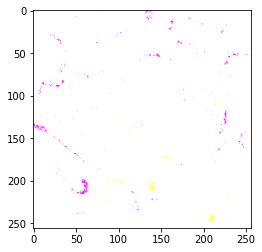

In [ ]:
show_sample(*train_ds[1541])

### DataLoaders

In [ ]:
batch_size = 64

In [ ]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, 
                      num_workers=3, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, 
                    num_workers=2, pin_memory=True)

In [ ]:
def show_batch(dl, invert=True):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        data = 1-images if invert else images
        ax.imshow(make_grid(data, nrow=16).permute(1, 2, 0))
        break

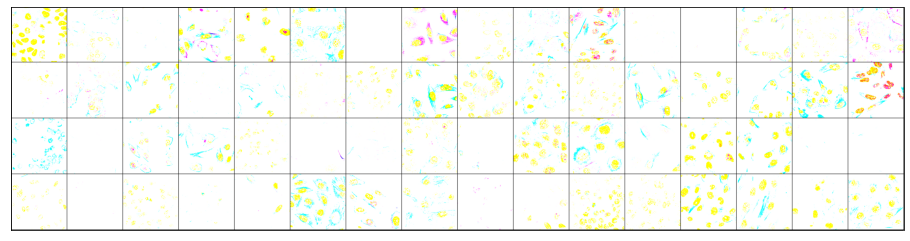

In [ ]:
show_batch(train_dl, invert=True)

## Model - Transfer Learning

In [ ]:
def F_score(output, label, threshold=0.5, beta=1):
    prob = output > threshold
    label = label > threshold

    TP = (prob & label).sum(1).float()
    TN = ((~prob) & (~label)).sum(1).float()
    FP = (prob & (~label)).sum(1).float()
    FN = ((~prob) & label).sum(1).float()

    precision = torch.mean(TP / (TP + FP + 1e-12))
    recall = torch.mean(TP / (TP + FN + 1e-12))
    F2 = (1 + beta**2) * precision * recall / (beta**2 * precision + recall + 1e-12)
    return F2.mean(0)

In [ ]:
class MultilabelImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, targets = batch 
        out = self(images)                      
        loss = F.binary_cross_entropy(out, targets)      
        return loss
    
    def validation_step(self, batch):
        images, targets = batch 
        out = self(images)                           # Generate predictions
        loss = F.binary_cross_entropy(out, targets)  # Calculate loss
        score = F_score(out, targets)
        return {'val_loss': loss.detach(), 'val_score': score.detach() }
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_scores = [x['val_score'] for x in outputs]
        epoch_score = torch.stack(batch_scores).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_score': epoch_score.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.4f}, train_loss: {:.4f}, val_loss: {:.4f}, val_score: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_score']))

[Learn about ResNets.](https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035)

Check out torchvision models: https://pytorch.org/docs/stable/torchvision/models.html

In [ ]:
resnet18 = models.resnet50()
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
class ProteinResnet(MultilabelImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 10)
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))
    
    def freeze(self):
        # To freeze the residual layers
        for param in self.network.parameters():
            param.require_grad = False
        for param in self.network.fc.parameters():
            param.require_grad = True
    
    def unfreeze(self):
        # Unfreeze all layers
        for param in self.network.parameters():
            param.require_grad = True

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

## Training

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
model = to_device(ProteinResnet(), device)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [ ]:
history = [evaluate(model, val_dl)]
history

[{'val_loss': 0.7628762722015381, 'val_score': 0.19020789861679077}]

First, freeze the ResNet layers and train some epochs. This only trains the final layer to start classifying the images.

In [ ]:
model.freeze()

In [ ]:
epochs = 13 

max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4

opt_func = torch.optim.Adam

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)


Epoch [0], last_lr: 0.0019, train_loss: 0.3022, val_loss: 0.3370, val_score: 0.4644



Epoch [1], last_lr: 0.0054, train_loss: 0.2873, val_loss: 0.3793, val_score: 0.4258



Epoch [2], last_lr: 0.0088, train_loss: 0.2902, val_loss: 0.3310, val_score: 0.4553



Epoch [3], last_lr: 0.0100, train_loss: 0.2913, val_loss: 0.3382, val_score: 0.4308



Epoch [4], last_lr: 0.0096, train_loss: 0.2840, val_loss: 1.1128, val_score: 0.2121



Epoch [5], last_lr: 0.0087, train_loss: 0.2793, val_loss: 0.3267, val_score: 0.5049



Epoch [6], last_lr: 0.0074, train_loss: 0.2703, val_loss: 0.3005, val_score: 0.4944



Epoch [7], last_lr: 0.0058, train_loss: 0.2640, val_loss: 0.2925, val_score: 0.5148



Epoch [8], last_lr: 0.0041, train_loss: 0.2568, val_loss: 0.2771, val_score: 0.5957



Epoch [9], last_lr: 0.0025, train_loss: 0.2483, val_loss: 0.3235, val_score: 0.4925



Epoch [10], last_lr: 0.0011, train_loss: 0.2392, val_loss: 0.2432, val_score: 0.6330



Epoch [11], last_lr: 0.0003, train_loss: 0.2303, val_loss: 0.2251, val_score: 0.6576



Epoch [12], last_lr: 0.0000, train_loss: 0.2250, val_loss: 0.2237, val_score: 0.6693
CPU times: user 6min 14s, sys: 2min 46s, total: 9min 1s
Wall time: 47min 33s


**Now, unfreeze and train some more.

In [ ]:
model.unfreeze()   
 .3

In [ ]:
%%time
history += fit_one_cycle(epochs, 0.001, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)


Epoch [0], last_lr: 0.0002, train_loss: 0.2235, val_loss: 0.2247, val_score: 0.6746



Epoch [1], last_lr: 0.0005, train_loss: 0.2251, val_loss: 0.2371, val_score: 0.6601



Epoch [2], last_lr: 0.0009, train_loss: 0.2254, val_loss: 0.2267, val_score: 0.6618



Epoch [3], last_lr: 0.0010, train_loss: 0.2259, val_loss: 0.2481, val_score: 0.5875



Epoch [4], last_lr: 0.0010, train_loss: 0.2226, val_loss: 0.2294, val_score: 0.6459



Epoch [5], last_lr: 0.0009, train_loss: 0.2217, val_loss: 0.2352, val_score: 0.6424



Epoch [6], last_lr: 0.0007, train_loss: 0.2187, val_loss: 0.2189, val_score: 0.6746



Epoch [7], last_lr: 0.0006, train_loss: 0.2159, val_loss: 0.2522, val_score: 0.6239



Epoch [8], last_lr: 0.0004, train_loss: 0.2118, val_loss: 0.2120, val_score: 0.6935



Epoch [9], last_lr: 0.0002, train_loss: 0.2078, val_loss: 0.2109, val_score: 0.6938



Epoch [10], last_lr: 0.0001, train_loss: 0.2053, val_loss: 0.2070, val_score: 0.7084



Epoch [11], last_lr: 0.0000, train_loss: 0.2029, val_loss: 0.2057, val_score: 0.7094



Epoch [12], last_lr: 0.0000, train_loss: 0.2027, val_loss: 0.2060, val_score: 0.7098
CPU times: user 6min 11s, sys: 2min 47s, total: 8min 58s
Wall time: 46min 51s


In [ ]:
%%time
history += fit_one_cycle(epochs, 0.001, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)


Epoch [0], last_lr: 0.0002, train_loss: 0.2021, val_loss: 0.2077, val_score: 0.7081



Epoch [1], last_lr: 0.0005, train_loss: 0.2056, val_loss: 0.2149, val_score: 0.6890



Epoch [2], last_lr: 0.0009, train_loss: 0.2094, val_loss: 0.2302, val_score: 0.6663



Epoch [3], last_lr: 0.0010, train_loss: 0.2128, val_loss: 0.2298, val_score: 0.6790



Epoch [4], last_lr: 0.0010, train_loss: 0.2112, val_loss: 0.2234, val_score: 0.6951



Epoch [5], last_lr: 0.0009, train_loss: 0.2104, val_loss: 0.2285, val_score: 0.6610



Epoch [6], last_lr: 0.0007, train_loss: 0.2074, val_loss: 0.4241, val_score: 0.5053


KeyboardInterrupt: 

In [ ]:
train_time='22:00'

In [ ]:
def plot_scores(history):
    scores = [x['val_score'] for x in history]
    plt.plot(scores, '-x')
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.title('F1 score vs. No. of epochs');

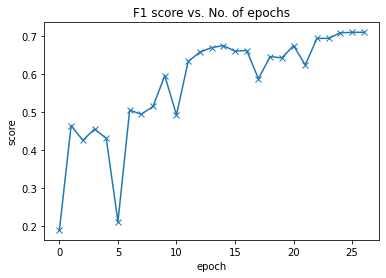

In [ ]:
plot_scores(history)

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

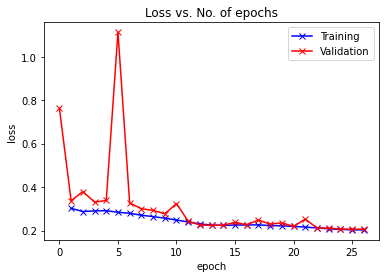

In [ ]:
plot_losses(history)

In [ ]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

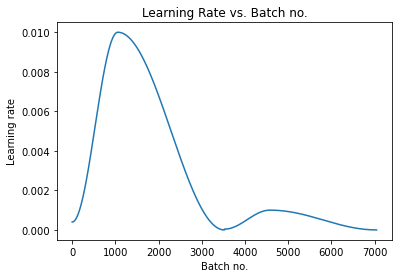

In [ ]:
plot_lrs(history)

## Making predictions and submission

In [ ]:
def predict_single(image):
    xb = image.unsqueeze(0)
    xb = to_device(xb, device)
    preds = model(xb)
    prediction = preds[0]
    print("Prediction: ", prediction)
    show_sample(image, prediction)

In [ ]:
test_df = pd.read_csv(TEST_CSV)
test_dataset = HumanProteinDataset(test_df, TEST_DIR, transform=valid_tfms)

In [ ]:
img, target = test_dataset[0]
img.shape

torch.Size([3, 256, 256])

Prediction:  tensor([0.0248, 0.0352, 0.0420, 0.0315, 0.4047, 0.0156, 0.1402, 0.0370, 0.0203,
        0.0168], device='cuda:0', grad_fn=<SelectBackward>)
Labels: 


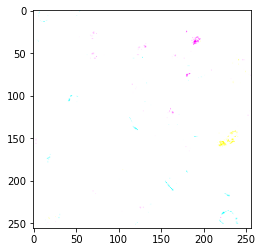

In [ ]:
predict_single(test_dataset[100][0])

Prediction:  tensor([0.0268, 0.0310, 0.0418, 0.0331, 0.3949, 0.0138, 0.1708, 0.0441, 0.0215,
        0.0165], device='cuda:0', grad_fn=<SelectBackward>)
Labels: 


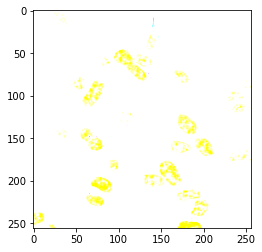

In [ ]:
predict_single(test_dataset[74][0])

In [ ]:
test_dl = DeviceDataLoader(DataLoader(test_dataset, batch_size, num_workers=3, pin_memory=True), device)

In [ ]:
@torch.no_grad()
def predict_dl(dl, model):
    torch.cuda.empty_cache()
    batch_probs = []
    for xb, _ in tqdm(dl):
        probs = model(xb)
        batch_probs.append(probs.cpu().detach())
    batch_probs = torch.cat(batch_probs)
    return [decode_target(x) for x in batch_probs]

In [ ]:
test_preds = predict_dl(test_dl, model)

In [ ]:
submission_df = pd.read_csv(TEST_CSV)
submission_df.Label = test_preds
submission_df.sample(20)

,Image,Label
5168,27233,
6336,26023,4
5962,2884,4 6
6513,27639,9
5100,12658,8
5971,24299,2
4931,23286,4
1,15322,4
5122,6801,4
6285,7597,3 4


In [ ]:
sub_fname = 'submission.csv'

In [ ]:
submission_df.to_csv(sub_fname, index=False)

## Save and Commit

In [ ]:
weights_fname = 'protein-resnet.pth'
torch.save(model.state_dict(), weights_fname)

In [ ]:
!pip install jovian --upgrade --quiet

In [ ]:
import jovian

<IPython.core.display.Javascript object>

In [ ]:
jovian.reset()
jovian.log_hyperparams(arch='resnet34', 
                       epochs=2*epochs, 
                       lr=max_lr, 
                       scheduler='one-cycle', 
                       weight_decay=weight_decay, 
                       grad_clip=grad_clip,
                       opt=opt_func.__name__)

[jovian] Please enter your API key ( from https://jovian.ml/ ):
API KEY: ········
[jovian] Hyperparams logged.


In [ ]:
jovian.log_metrics(val_loss=history[-1]['val_loss'], 
                   val_score=history[-1]['val_score'],
                   train_loss=history[-1]['train_loss'],
                   time=train_time)

[jovian] Metrics logged.


In [ ]:
project_name='protein-advanced'

In [ ]:
jovian.commit(project=project_name, environment=None, outputs=[weights_fname])

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ml/jaisal1311/protein-advanced


<IPython.core.display.Javascript object>